In [37]:
import warnings
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns

# Analysis of results

## Calculate mean of the iterations of each parameter set 

In [38]:
# Prepare dataFrame to store mean values
df_output = pd.DataFrame(columns=["CAR_DRIVER", "CAR_PASSENGER", "BIKE", "BUS_TRAM", "TRAIN", "WALK"])

df_output

,CAR_DRIVER,CAR_PASSENGER,BIKE,BUS_TRAM,TRAIN,WALK


In [39]:
warnings.filterwarnings("ignore")

folder_path = 'output/iterations'

# Iterate through each CSV file in the folder
for filename in os.listdir(folder_path):
    #print(filename)
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Calculate the mean of each column
        mean_values = df.mean()
        
        #print(mean_values)
                        
        # Append the mean values to the new DataFrame       
        df_output.loc[len(df_output)] = mean_values
        
# Enable warnings again
warnings.filterwarnings("default")

In [40]:
df_output

,CAR_DRIVER,CAR_PASSENGER,BIKE,BUS_TRAM,TRAIN,WALK
0,0.029042,0.055251,0.280208,0.237212,0.020263,0.378024
1,0.030824,0.063079,0.186901,0.226334,0.027643,0.465218
2,0.027745,0.043872,0.247660,0.215143,0.024183,0.441396
3,0.030796,0.067068,0.202426,0.278584,0.030798,0.390329
4,0.022430,0.058587,0.127174,0.153452,0.016896,0.621461
...,...,...,...,...,...,...
61,0.002572,0.002766,0.001315,0.006265,0.084339,0.902745
62,0.001924,0.002193,0.001360,0.004909,0.086810,0.902804
63,0.015298,0.069697,0.133656,0.120769,0.010254,0.650326
64,0.020905,0.038301,0.270495,0.156898,0.015045,0.498355


## Link means with parameter set for evaluation

In [41]:
# read parameters that were run
df_input = pd.read_csv('data/parametersets_to_run.csv')

# check that everything matches
print(df_output.shape[0])
print(df_input.shape[0])
print(df_output.shape[0] == df_input.shape[0])

# put parameters and results together
df = pd.concat([df_input, df_output], axis=1)

66
66
True


In [42]:
df

,alphaWalk,alphaBike,alphaCarDriver,alphaCarPassenger,alphaBus,alphaTrain,betaTimeWalk,betaTimeBike,betaTimeCarDriver,betaTimeCarPassenger,...,betaTimeWalkTransport,betaChangesTransport,used_parameter_label,used_parameter_value,CAR_DRIVER,CAR_PASSENGER,BIKE,BUS_TRAM,TRAIN,WALK
0,-10.0,0.0,0.0,0.0,0.0,0.0,-0.04,-0.03,-0.02,-0.02,...,-0.03,-0.3,alphaWalk,-10.0,0.029042,0.055251,0.280208,0.237212,0.020263,0.378024
1,-8.0,0.0,0.0,0.0,0.0,0.0,-0.04,-0.03,-0.02,-0.02,...,-0.03,-0.3,alphaWalk,-8.0,0.030824,0.063079,0.186901,0.226334,0.027643,0.465218
2,-6.0,0.0,0.0,0.0,0.0,0.0,-0.04,-0.03,-0.02,-0.02,...,-0.03,-0.3,alphaWalk,-6.0,0.027745,0.043872,0.247660,0.215143,0.024183,0.441396
3,-4.0,0.0,0.0,0.0,0.0,0.0,-0.04,-0.03,-0.02,-0.02,...,-0.03,-0.3,alphaWalk,-4.0,0.030796,0.067068,0.202426,0.278584,0.030798,0.390329
4,-2.0,0.0,0.0,0.0,0.0,0.0,-0.04,-0.03,-0.02,-0.02,...,-0.03,-0.3,alphaWalk,-2.0,0.022430,0.058587,0.127174,0.153452,0.016896,0.621461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.0,0.0,0.0,0.0,0.0,2.0,-0.04,-0.03,-0.02,-0.02,...,-0.03,-0.3,alphaTrain,2.0,0.002572,0.002766,0.001315,0.006265,0.084339,0.902745
62,0.0,0.0,0.0,0.0,0.0,4.0,-0.04,-0.03,-0.02,-0.02,...,-0.03,-0.3,alphaTrain,4.0,0.001924,0.002193,0.001360,0.004909,0.086810,0.902804
63,0.0,0.0,0.0,0.0,0.0,6.0,-0.04,-0.03,-0.02,-0.02,...,-0.03,-0.3,alphaTrain,6.0,0.015298,0.069697,0.133656,0.120769,0.010254,0.650326
64,0.0,0.0,0.0,0.0,0.0,8.0,-0.04,-0.03,-0.02,-0.02,...,-0.03,-0.3,alphaTrain,8.0,0.020905,0.038301,0.270495,0.156898,0.015045,0.498355


# Plot linear regressions

In [43]:
threshold_slope_abs = 0.000 # possibility to filter out parameters without much impact

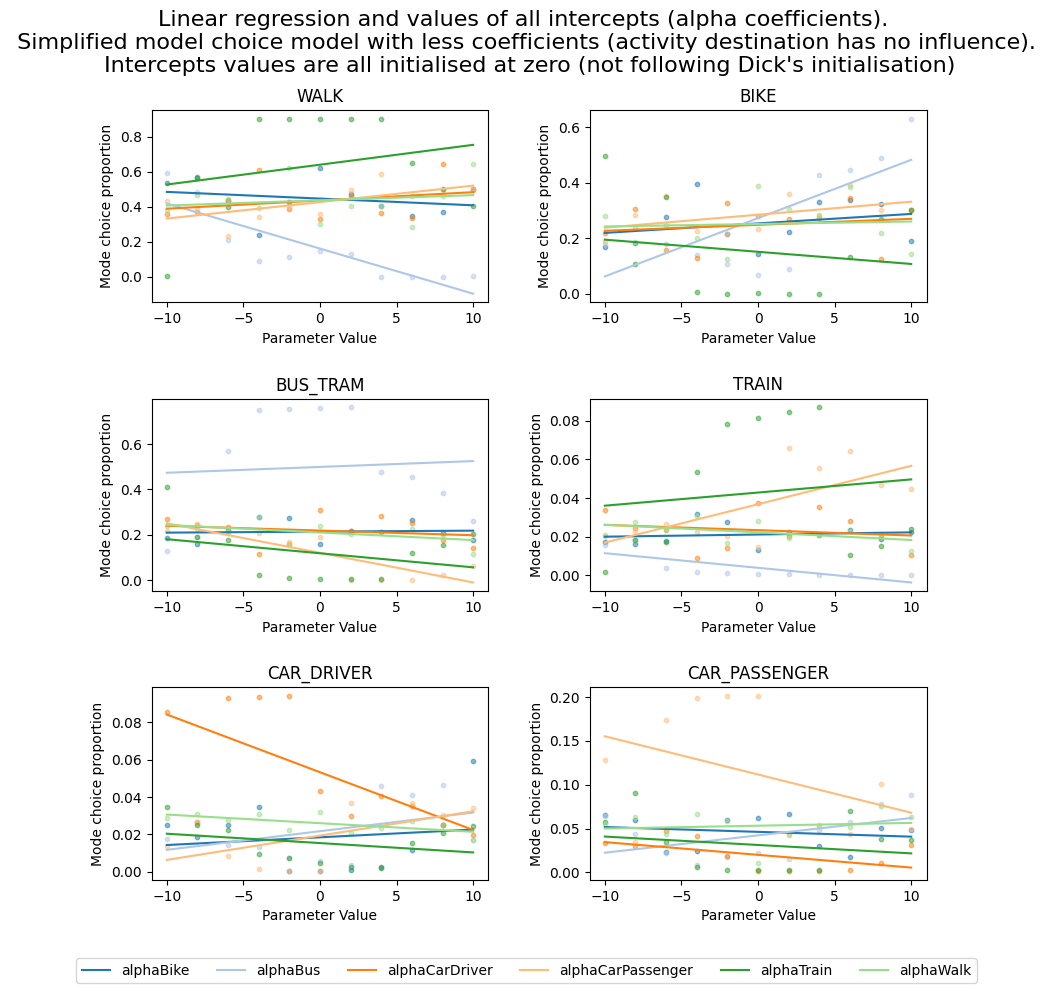

In [47]:
# Initialize an empty list to store parameter names with slope > 0.1
params_with_slope = []

groups = df.groupby('used_parameter_label')

output_cols = ['WALK', 'BIKE', 'BUS_TRAM', 'TRAIN', 'CAR_DRIVER', 'CAR_PASSENGER']

# Loop over each group and calculate the slope for each parameter
for name, group in groups:
    for col in output_cols:
        # Calculate the slope for this parameter and output column
        slope, intercept = np.polyfit(group['used_parameter_value'], group[col], 1)
        
        # Check if the absolute value of the slope is greater than 0.1
        if abs(slope) > threshold_slope_abs:
            # Add the parameter name to the list
            params_with_slope.append(name)
            break  # Only need to add the parameter name once

# Filter the dataframe to only include rows with parameter names in params_with_slope
df_filtered = df[df['used_parameter_label'].isin(params_with_slope)]

# Group the filtered data by parameter name
groups_filtered = df_filtered.groupby('used_parameter_label')

# Create a new figure with a 3x2 grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

# Initialize a dictionary to store the colors for each group
colors = {}

# Loop over each output column and plot the data in a separate subplot
for i, col in enumerate(output_cols):
    # Get the axis object for this subplot
    ax = axs[i // 2, i % 2]
    
    j = 0
    # Loop over each group and plot the data for this output column
    for name, group in groups_filtered:
        # Extract the x and y values for this group and output column
        x = group['used_parameter_value']
        y = group[col]
        
        # Assign a color to this group based on its name
        if name not in colors:
            colors[name] = plt.cm.tab20(j)
        
        # Plot the data points
        slope, intercept = np.polyfit(x, y, 1)
        regression_line = intercept + slope * x
        ax.plot(x, regression_line, label=name, color=colors[name])
        
        
        ax.scatter(x, y, label=name, color=colors[name], alpha=0.5, s = 10)
        
        j=j+1
    
    # Set the title for this subplot to the name of the output column
    ax.set_title(col)
    
    # Set the axis labels for this subplot
    ax.set_xlabel('Parameter Value')
    ax.set_ylabel('Mode choice proportion')
    
# Create a legend for the whole figure
handles, labels = [], []
for name, group in groups_filtered:
    for col in output_cols:
        if name in params_with_slope:
            # Check if the parameter name has already been added to the labels list
            if name not in labels:
                # Add a handle to the handles list for this parameter name
                handle = plt.plot([], [], label=name, color=colors[name])[0]
                handles.append(handle)
                labels.append(name)

fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=len(labels))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Title
fig.suptitle('Linear regression and values of all intercepts (alpha coefficients).', fontsize=16)

# Save
plt.savefig('plot_slopes_'+str(threshold_slope_abs)+'.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()